In [1]:
import os 
import time
import pandas as pd


import keras 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTransposeb
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from keras import layers

from tensorflow.keras import backend as K
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score


2023-03-07 15:15:11.292415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 15:15:11.370464: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 15:15:11.373039: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 15:15:11.373051: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [2]:
# import warnings
# warnings.filterwarnings("ignore") 

# Description des jeux de donnée :
**Cas d'étude:** Vibrations de moteur d'appareil éléctrique 

**Spécificitées des  données:** Series temporelles avec des erreurs d'acquision de capteurs et des anomalies de fréquences

**Détécter les erreurs d'acquisistion sous forme de pics ( Méthode non supérvisé ):** 1 Dataset

**Detection semi-supérvisé des signaux d'usure des rollements:** 1 Train et 2 Test datasets


# Détécter les erreurs d'acquisistion sous forme de pics ( Méthode non supérvisé )

In [3]:
raw_data = pd.read_csv('Datasets2/Train/device_1.csv', index_col='ts')

In [4]:
raw_data.describe()

,value,label
count,100037.000000,100037.000000
mean,0.009184,0.154983
std,1.700410,0.368731
min,-102.153964,0.000000
25%,-0.637260,0.000000
50%,0.007909,0.000000
75%,0.641142,0.000000
max,91.085782,2.000000


<Axes: xlabel='ts'>

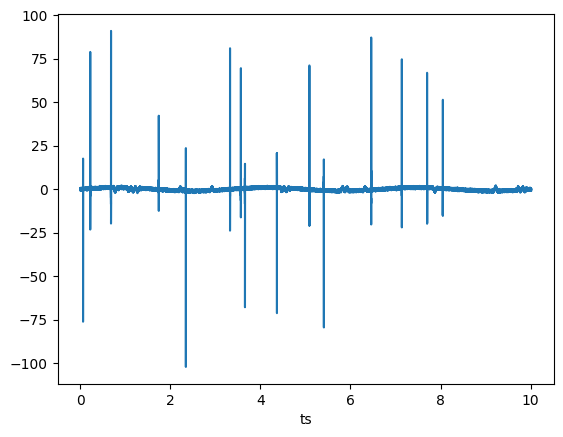

In [5]:
raw_data['value'].plot()

## Creation de modèle (LSTM AutoEncodeur)

In [6]:
def LSTMAE(nb_entries, width, loss="MSE"):
        """
        Sets up the architecture that will be used for the autoencoder
    
            Parameters: 
        
                nb_entries: an integer representing the number of rows of the spectrograms images
                width: an integer representing the number of columns of the spectrograms images
        
            Returns:
                model: convolutional autoencoder
        """
        valid_shape = (width, nb_entries)
        model = Sequential()
        model.add(LSTM(64, activation='relu', input_shape=valid_shape, return_sequences=True))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(units=10,activation="relu", name="latent"))
        model.add(BatchNormalization())
        model.add(Dense(32, activation='relu'))
        model.add(LSTM(64, activation='sigmoid', return_sequences=True))
        model.add(TimeDistributed(Dense(nb_entries)))
        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss=loss)
        return model

## Formatage et pre-processing de la donnée

In [7]:
WINDOW_SIZE = 30

In [9]:
def build_rolling_data(data,window):
    rolling_data = np.lib.stride_tricks.as_strided(data, (len(data) - window + 1, window),(data.strides[0], data.strides[0]))
    rolling_data = tf.expand_dims(rolling_data,axis=-1)
    return rolling_data

In [10]:
scaler = MinMaxScaler()
# minmax scaler formula X_scaled = X-min(X) / max(X)-min(X)
# Scales data between 0 and 1
data = raw_data.value.values
Normalized_data = scaler.fit_transform(data.reshape(-1,1))
rolling_normalized_data = build_rolling_data(Normalized_data,WINDOW_SIZE)

2023-03-07 15:15:16.831983: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-07 15:15:16.832016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ye
2023-03-07 15:15:16.832019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ye
2023-03-07 15:15:16.832125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.78.1
2023-03-07 15:15:16.832143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  525.78.01  Release Build  (dvs-builder@U16-J11-10-2)  Mon Dec 26 05:50:21 UTC 2022
GCC version:  gcc version 9.4.0 (Ubuntu 9.4.0-1ubuntu1~20.04.1) 
"
2

## Apprentissage du modèle 

In [11]:
# Build LSTM AutoEncoder for unidimentional time series
model = LSTMAE(1, WINDOW_SIZE)

In [12]:
start = time.time()
model.fit(rolling_normalized_data,rolling_normalized_data,epochs= 20, verbose = True, batch_size=128)
print(f"model trained in {(time.time()-start)/60} minutes")

Epoch 1/20
782/782 [==============================] - 28s 34ms/step - loss: 0.0020
Epoch 2/20
782/782 [==============================] - 26s 33ms/step - loss: 5.9064e-05
Epoch 3/20
782/782 [==============================] - 26s 34ms/step - loss: 3.7351e-05
Epoch 4/20
782/782 [==============================] - 25s 32ms/step - loss: 1.7656e-05
Epoch 5/20
782/782 [==============================] - 28s 36ms/step - loss: 1.6985e-05
Epoch 6/20
782/782 [==============================] - 32s 41ms/step - loss: 2.1302e-05
Epoch 7/20
782/782 [==============================] - 33s 42ms/step - loss: 2.7531e-05
Epoch 8/20
782/782 [==============================] - 34s 43ms/step - loss: 2.2955e-05
Epoch 9/20
782/782 [==============================] - 32s 41ms/step - loss: 1.9138e-05
Epoch 10/20
782/782 [==============================] - 33s 42ms/step - loss: 1.8140e-05
Epoch 11/20
782/782 [==============================] - 30s 39ms/step - loss: 1.4240e-05
Epoch 12/20
782/782 [========================

## Prediction 

In [13]:
predicted = model.predict(rolling_normalized_data)

3126/3126 [==============================] - 36s 12ms/step


In [14]:
reconstruction_error = np.mean((rolling_normalized_data-predicted)**2, axis =1)

In [15]:
# the threshold is the  average of reconstruction error + 3 std reconstruction error
# The predicted anomalies are the points with a decision inferior to 0 <=> reconstruction error > threshold
decision = -reconstruction_error + np.mean(reconstruction_error)+3*np.std(reconstruction_error)

In [17]:
padding = [0]*(len(raw_data)-len(decision)) # creating a padding for the decision list to match size of initial data

In [19]:
raw_data['predict'] = list(decision.flatten()) + padding

In [20]:
# the anomalies are the points with an initial predict value inferior to 0
raw_data['predict'] = raw_data['predict'].apply(lambda x : 25 if x < 0 else 0)

## Visualisation 

<Axes: xlabel='ts'>

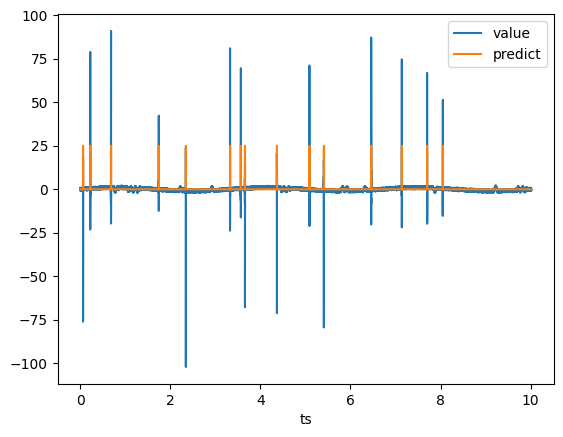

In [21]:
raw_data[['value','predict']].plot()

# Detection semi-supérvisé des signaux d'usure des roulements

## Import des données

In [22]:
train_data_2 = pd.read_csv("Datastest5/train.csv")
test_data_2 = pd.read_csv("Datastest5/test.csv")

In [72]:
# train_data_2[['value','Class']].plot()

## Creation de modèle ( CNN AE ) 

In [25]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=100):
        # initialize the input shape to be "channels last" along with
        # the channels dimension itself
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1
        # define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs
        # loop over the number of filters
        for f in filters:
        # apply a CONV => RELU => BN operation
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        # flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        # build the encoder model
        encoder = Model(inputs, latent, name="encoder")
        # start building the decoder model which will accept the
        # output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        # loop over our number of filters again, but this time in
        # reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2,
                padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        # apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        # build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder")
        # our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)),
        name="autoencoder")
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        autoencoder.compile(loss="mse", optimizer=optimizer)
        return autoencoder

## Preparation des données

In [26]:
def build_spectrograms(data,window,saving_folder,step,label_col = 'Class'):
    i = 0
    range_df = i*step
    while range_df+window < len(data):
        range_df = i*step
        y = data[range_df:range_df+window].value.values
        img_class = 1 if data[range_df:range_df+window][label_col].sum() > 0.3*window else  0
        S_left = librosa.stft(y, center=True, n_fft=int(window/2))
        fig, ax = plt.subplots()
        img = librosa.display.specshow(librosa.amplitude_to_db(S_left,
                                                               ref=np.max),
                                       y_axis='log', x_axis='time', ax=ax)
        ax.set_title('Power spectrogram')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")
        plt.savefig(f"{saving_folder}/class_{img_class}/{range_df}_{range_df+window-1}.png")
        i+=1


In [27]:
# build_spectrograms(train_data_2,100,"Spectrograms6/Train",1)
# build_spectrograms(test_data_2,100,"Spectrograms6/Test",1)


## Chargement des spectrogrammes

In [28]:
#chargement custom des données de spéctrogramme de train
train_folder = "Spectrograms6/Train"
train_images = []
ano_images = [] 
class_data = ["class_0","class_1"]
for label in class_data:
    for i,img in enumerate(os.listdir(f"{train_folder}/{label}/")):
        if 'png' in img:
            image = tf.keras.utils.load_img(f"{train_folder}/{label}/{img}",color_mode = "grayscale",target_size=(100, 100))
            input_arr = tf.keras.utils.img_to_array(image)/255.0
            if label == "class_0":    
                train_images.append(input_arr)
            else:
                ano_images.append(input_arr)


In [29]:
X_train0_CAE = np.array(train_images) # spectrograms de données normal train
X_train1_CAE = np.array(ano_images) # spectrograms de données anormal train

In [30]:
#chargement custom des données de spéctrogramme de test
test_folder = "Spectrograms6/Test"
test_images0 = []
test_images1 = [] 
class_data = ["class_0","class_1"]
for label in class_data:
    for i,img in enumerate(os.listdir(f"{test_folder}/{label}/")):
        if 'png' in img:
            image = tf.keras.utils.load_img(f"{test_folder}/{label}/{img}",color_mode = "grayscale",target_size=(100, 100))
            input_arr = tf.keras.utils.img_to_array(image)/255.0
            if label == "class_0":    
                test_images0.append(input_arr)
            else:
                test_images1.append(input_arr)

In [32]:
X_test0CAE = np.array(test_images0) # spectrograms de données normal test
X_test1CAE = np.array(test_images1) # spectrograms de données anormal test

## Apprentissage du modèle

In [33]:
CAE = ConvAutoencoder.build(100, 100, 1) # construction de l'architecture

In [34]:
start = time.time()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
CAE.fit(X_train0_CAE,X_train0_CAE, epochs=20, verbose = True, callbacks= [callback])
print(f"model trained in {(time.time()-start)/60} minutes")


Epoch 1/20
88/88 [==============================] - 10s 107ms/step - loss: 0.0233
Epoch 2/20
88/88 [==============================] - 9s 107ms/step - loss: 0.0044
Epoch 3/20
88/88 [==============================] - 9s 107ms/step - loss: 0.0039
Epoch 4/20
88/88 [==============================] - 9s 107ms/step - loss: 0.0034
Epoch 5/20
88/88 [==============================] - 9s 106ms/step - loss: 0.0014
Epoch 6/20
88/88 [==============================] - 9s 106ms/step - loss: 7.4123e-04
Epoch 7/20
88/88 [==============================] - 11s 123ms/step - loss: 4.2717e-04
Epoch 8/20
88/88 [==============================] - 12s 131ms/step - loss: 3.9586e-04
Epoch 9/20
88/88 [==============================] - 12s 133ms/step - loss: 4.1487e-04
Epoch 10/20
88/88 [==============================] - 11s 130ms/step - loss: 3.8949e-04
Epoch 11/20
88/88 [==============================] - 12s 131ms/step - loss: 3.1519e-04
Epoch 12/20
88/88 [==============================] - 11s 121ms/step - loss: 3

## Prediction

In [35]:
predictions0CAE = CAE.predict(X_train0_CAE) # normal data predictions
predictions1CAE = CAE.predict(X_train1_CAE) # anomalies predictions

2/2 [==============================] - 0s 35ms/step


In [50]:
r_e_CAE = np.sum(np.sum((X_train0_CAE-predictions0CAE) ** 2, axis=1),axis = 1) # computing reconstruction error of normal train data 
r_e_anos_CAE = np.sum(np.sum((X_train1_CAE-predictions1CAE) ** 2, axis=1),axis = 1) # computing reconstruction error of abnormal train data 
threshold_t_CAE = np.quantile(r_e_CAE,0.999) # setting reconstruction error threshold

In [37]:
prediction_test0CAE = CAE.predict(X_test0CAE)
prediction_test1CAE = CAE.predict(X_test1CAE)

1/1 [==============================] - 0s 50ms/step


In [38]:
r_e_test0CAE = np.sum(np.sum((X_test0CAE-prediction_test0CAE) ** 2, axis=1),axis=1)
r_e_test1CAE = np.sum(np.sum((X_test1CAE-prediction_test1CAE) ** 2, axis=1),axis=1)

In [51]:
decision0CAE = -r_e_test0CAE + threshold_t_CAE
decision1CAE = -r_e_test1CAE + threshold_t_CAE
df0CAE = pd.DataFrame(decision0CAE, columns=['v'])
df1CAE = pd.DataFrame(decision1CAE, columns=['v'])

In [52]:
# computing f1 score of minority class
recall = len(df1CAE[df1CAE.v<0])/len(df1CAE)
precision = len(df1CAE[df1CAE.v<0])/(len(df1CAE[df1CAE.v<0])+len(df0CAE[df0CAE.v<0]))
f1 = 2*precision*recall/(precision+recall)

In [44]:
# computing f1 score of majority class
recall_maj = len(df0CAE[df0CAE.v>0])/len(df0CAE)
precision_maj = len(df0CAE[df0CAE.v>0])/(len(df1CAE[df1CAE.v>0])+len(df0CAE[df0CAE.v>0]))
f1_maj = 2*precision_maj*recall_maj/(precision_maj+recall_maj)

### Test score

In [56]:
print(f"Test scores:")
print(f"minority class F1 score {f1}")
print(f"majority class F1 score {f1_maj}")
print(f"average F1 score {(f1+f1_maj)/2}")

Test scores:
minority class F1 score 0.896551724137931
majority class F1 score 0.9941228851291184
average F1 score 0.9453373046335247


## Detection supérvisé des signaux d'usure des roulements

## Import des données

In [57]:
image_size = (100,100)
train_data3 = tf.keras.utils.image_dataset_from_directory("Spectrograms6/Train/",image_size=image_size,seed = 0,validation_split = 0.2,color_mode = 'grayscale', subset='both',label_mode='categorical')
test_data3 = tf.keras.utils.image_dataset_from_directory("Spectrograms6/Test/",image_size=image_size,color_mode = 'grayscale',label_mode='categorical')
test2_data3 = tf.keras.utils.image_dataset_from_directory("Spectrograms6/Test2/",image_size=image_size,color_mode = 'grayscale',label_mode='categorical')

Found 2855 files belonging to 2 classes.
Using 2284 files for training.
Using 571 files for validation.
Found 2850 files belonging to 2 classes.
Found 2849 files belonging to 2 classes.


## Creation de modèle CNN classifier 

In [58]:
def CNN_classifier(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [32,64]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 2
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [59]:
# redefinition des metrics 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [61]:
model = CNN_classifier(input_shape=image_size + (1,), num_classes=2)

In [62]:
start = time.time()

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[f1_m],
)
model.fit(
    train_data3[0],
    epochs=20,
    validation_data=train_data3[1],
)
print(f"model trained in {(time.time()-start)/60} minutes")

Epoch 1/20
71/72 [============================>.] - ETA: 0s - loss: 0.0659 - f1_m: 0.9809

2023-03-07 15:40:50.372076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/add_1/add' exist for missing node 'model/add/add'.
2023-03-07 15:40:50.386353: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/add_1/add' exist for missing node 'model/add/add'.


72/72 [==============================] - 8s 96ms/step - loss: 0.0656 - f1_m: 0.9812 - val_loss: 0.5201 - val_f1_m: 0.9806
Epoch 2/20
72/72 [==============================] - 7s 95ms/step - loss: 0.0101 - f1_m: 0.9976 - val_loss: 0.3703 - val_f1_m: 0.9806
Epoch 3/20
72/72 [==============================] - 7s 94ms/step - loss: 0.0049 - f1_m: 0.9987 - val_loss: 0.3576 - val_f1_m: 0.9806
Epoch 4/20
72/72 [==============================] - 7s 95ms/step - loss: 0.0038 - f1_m: 0.9996 - val_loss: 1.7803 - val_f1_m: 0.0194
Epoch 5/20
72/72 [==============================] - 7s 95ms/step - loss: 0.0012 - f1_m: 0.9998 - val_loss: 4.3210 - val_f1_m: 0.0194
Epoch 6/20
72/72 [==============================] - 7s 96ms/step - loss: 0.0033 - f1_m: 0.9980 - val_loss: 0.4372 - val_f1_m: 0.8705
Epoch 7/20
72/72 [==============================] - 7s 95ms/step - loss: 0.0044 - f1_m: 0.9993 - val_loss: 0.0181 - val_f1_m: 1.0000
Epoch 8/20
72/72 [==============================] - 7s 96ms/step - loss: 0.0023 

In [67]:
test_1_score = model.evaluate(test_data3)[1]

90/90 [==============================] - 3s 34ms/step - loss: 0.0147 - f1_m: 0.9986


In [71]:
print('Test score:')
print(f"average F1 score {test_1_score}")

Test score:
average F1 score 0.9986110925674438


In [69]:
# model.evaluate(test2_data3)